Name: Jingyue Xu

Group number: 1

# Instructions:
**To start working on this Homework, create a copy of this notebook and save it within your Google Drive (File -> Save a copy in Drive).**

This Jupyter notebook contains 4 exercises consisting of coding and discussion questions. For the discussion questions, please write your answer within a new text cell. Please hand in your .ipynb file (File -> Download -> Download .ipynb) on canvas by midnight on **April 18th**.

To execute the code, it is necessary to load some external packages, so please execute the following code block.

In [10]:
# @title Load packages
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Exercise 1 - The Hodgkin Huxley model

## 1a.
Simulate a Hodgkin Huxley (HH) neuron subject to a single pulse current injection.
  * Plot the voltage as a function of time for different current amplitudes.
  * What is the spike threshold?
  * Bonus: Does the spike threshold depend on the duration of the pulse?

## 1b.
Simulate a HH neuron subject to a direct (constant) current injection.
* Characterize the voltage response as function of the current amplitude.
* Plot the f-I curve.

## 1c.
For the HH neuron in Exercise 1a,
* Pick a current amplitude above the spiking threshold.
* For each pair of variables V, m, n, h (6 pairs), plot one variable as a function of the other. 
* Identify pairs that are most strongly correlated. 
  How can this identification help in reducing the neuron model’s dimension?

* Does the choice of current amplitude affect which pairs of variables are most correlated?



To implement the HH model, you will need to implement the equations to model the Sodium, Potassium, and Leak currents:

All the equations necessary to model the Sodium current:

\begin{align}
  I_{Na}   &= \bar{g}_{Na} m^3 h (V-E_{Na})\\
  \alpha_m &= 0.1 \frac{V+40}{1-e^{-\frac{V+40}{10}}} \\
  \beta_m  &= 4 e^{-\frac{V+65}{18}} \\
  \tau_m &= \frac{1}{\alpha_m(V) + \beta_m(V)} \\
  m_0 &= \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)}\\
  \frac{dm}{dt} &= -\frac{1}{\tau_m (V)}[m-m_0(V)] \\
  \alpha_h &= 0.07 e^{-\frac{V+65}{20}} \\
  \beta_h  &= \frac{1}{1+e^{-\frac{V+35}{10}}} \\
  \tau_h &= \frac{1}{\alpha_h(V) + \beta_h(V)} \\
  h_0 &= \frac{\alpha_h(V)}{\alpha_h(V) + \beta_h(V)}\\
  \frac{dh}{dt} &= -\frac{1}{\tau_h (V)}[h-h_0(V)] \\
\end{align}

All the equations necessary to model the Potassium current:
\begin{align}
  I_{K}   &= \bar{g}_{K} n^4 (V-E_{K})\\
  \alpha_n &= 0.01 \frac{V+55}{1-e^{-\frac{V+55}{10}}} \\
  \beta_n  &= 0.125 e^{-\frac{V+65}{80}}\\
  \tau_n &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
  n_0 &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}\\
  \frac{dn}{dt} &= -\frac{1}{\tau_n (V)}[n-n_0(V)] \\
\end{align}

All the equations to model the Leak current:
\begin{align}
  I_{L}   &= \bar{g}_{L} (V-E_{L})\\
\end{align}

Finally, the equation to model the change in the membrane potential due to some injected current $I_{inj}$:
$$ \frac{dV}{dt} = (I_{inj}(t) - I_{Na} - I_K - I_L)/ C_m $$

Some general hints:

For creating plots, we have imported matplotlib's pyplot package above. Be sure to read up on the official [documentation](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) in case you get stuck. I have listed some functions that could be helpful below:


*   plt.[figure()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.figure.html) - Create a new figure.
* plt.[subplot()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.subplot.html) - Useful for creating multiple plots in one figure (for further information, see [here](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/multiple_figs_demo.html)).
*   plt.[plot()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot) -  	Plot y versus x as lines and/or markers.
* plt.[title()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.title.html#matplotlib.pyplot.title) - Set a Title.
* plt.[xlabel()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.xlabel.html#matplotlib.pyplot.xlabel) / plt.ylabel() - Label the axes.
* plt.[hist()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist) - Plot a histogram.
* plt.[scatter()](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter) - Plot a scatter plot.



For example, a simple plot of the sine and the cosine function could look like this:
```
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 5, 0.1)
y = np.sin(x)
y2= np.cos(x)
plt.plot(x, y, label='sin(x)')  # plot y as a function of x
plt.plot(x, y2, label='cos(x)') # plot y2 as a function of x

plt.title('Some title')    # set a title
plt.xlabel('X')            # label the x-axis
plt.ylabel('Y')            # label the y-axis
plt.legend()               # create a legend
plt.show()                 # show the plot. (not necessary for Jupyter notebooks/ Colab)

```

**Useful Resources**:
[Neuronal Dynamics, Chapter 2.2](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html#Ch2.F3)



In [111]:
class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""
    def __init__(self,time):
        self.t = time

    # HH Constants                                           
    C_m  =   1.0    # [uF/cm^2] membrane capacitance
    g_Na = 120.0    # [mS/cm^2] Sodium (Na) maximum conductance
    g_K  =  36.0    # [mS/cm^2] Postassium (K) maximum conductance
    g_L  =   0.3    # [mS/cm^2] Leak maximum conductance

    E_Na =  50.0    # [mV] Sodium (Na) Nernst reversal potential
    E_K  = -77.0    # [mV] Potassium (K) Nernst reversal potential
    E_L  = -54.387  # [mV] Leak Nernst reversal potential

    # Define sodium activation, m
    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*np.exp(-(V+65.0)/18.0)

    def tau_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(self.alpha_m(V)+self.beta_m(V))

    def m_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return self.alpha_m(V)*self.tau_m(V)

    # Define sodium inactivation, h
    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65.0)/20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0+np.exp(-(V+35.0)/(10.0)))

    def tau_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(self.alpha_h(V)+self.beta_h(V))

    def h_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return self.alpha_h(V)*self.tau_h(V)

    # Define potassium activation, n
    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1-np.exp(-(V+55.0)/(10.0)))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65.0)/(80.0))

    def tau_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(self.alpha_n(V)+self.beta_n(V))

    def n_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return self.alpha_n(V)*self.tau_n(V)

    # Calculate ion current
    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)
        """
        return self.g_Na*(m**3.0)*h*(V-self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)
        """
        return self.g_K*(n**4.0)*(V-self.E_K)
    
    # Leak 
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak
        """
        return self.g_L*(V-self.E_L)

    # Injection current
    def I_inj(self, t, iinj):
        """
        External Current
        """
        return iinj[0]*(t>iinj[1]) - iinj[0]*(t>iinj[2])

    @staticmethod
    def dALLdt(X, t, self):
        """
        Calculate the change in each of the variables.

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t, self.iinj)-self.I_Na(V, m, h)-self.I_K(V, n)-self.I_L(V))/self.C_m
        dmdt = -1.0/self.tau_m(V)*(m-self.m_0(V))
        dhdt = -1.0/self.tau_h(V)*(h-self.h_0(V))
        dndt = -1.0/self.tau_n(V)*(n-self.n_0(V))
        return dVdt, dmdt, dhdt, dndt

    def HH_EX1a(self, iamp, tstep):
        """
        Simulate a Hodgkin Huxley (HH) neuron subject to a single pulse current injection.

        Plot the voltage as a function of time for different current amplitudes.
        What is the spike threshold?
        Bonus: Does the spike threshold depend on the duration of the pulse?
        
        (Hint: you can use the odeint function to integrate a system of equations.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)
        Example:
            X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
            V = X[:,0]
            m = X[:,1]
            h = X[:,2]
            n = X[:,3]
        Here, the [-65, 0.05, 0.6, 0.32] are the initial values for V, m, h, and n respectively.

        I used the parameters iamp and tstep to represent the amplitude and the start/stop of
        some external input. You can feel free to define it in a similar fashion, or implement
        your own way of getting the injected current.
        """

        fig1 = plt.figure(1, figsize = (5, 2.5*len(iamp)), tight_layout = True)
        index = 1
        for i0 in range(0,np.size(iamp)):           # loop over different amplidtudes
          self.iinj = [iamp[i0],tstep[0],tstep[1]]  # set the amplitude and start/ stop of the injected step current
          X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,)) # integrate the values over time
          V = X[:,0] # access all of the values for V
          m = X[:,1]
          h = X[:,2]
          n = X[:,3]
          
          # Plot the voltage as a function of time for different current amplitudes.
          plt.figure(1)
          plt.subplot(len(iamp), 1, index)
          plt.plot(self.t, V)
          plt.xlim([0,50])
          plt.ylim([-90,50])
          plt.title("HH Neuron Simulated to a Single Pulse\n" + "Current Injection with Amplitude " + str(index))
          plt.xlabel("Time, t (ms)")
          plt.ylabel("Voltage, V (mV)")

          # What is the spike threshold?

          blVIndex = int(tstep[0]/(self.t[1]-self.t[0])) + 1
          peak = sps.find_peaks(V)
          peakIndex = peak[0][0]
          if V[peakIndex] > 0:
            I_sum = abs(self.I_Na(V[blVIndex:peakIndex], m[blVIndex:peakIndex], h[blVIndex:peakIndex]) + self.I_K(V[blVIndex:peakIndex], n[blVIndex:peakIndex]) + self.I_L(V[blVIndex:peakIndex]))
            thresholdIndex = np.where(I_sum == I_sum.min())[0][0] + blVIndex
            threshold = V[thresholdIndex]
            print("The spike threshold for current amplitude " + str(index) + " is " + str(round(threshold, 2)) + "mV")

          index = index + 1

        # Bonus: Does the spike threshold depend on the duration of the pulse?
        ...

    def HH_EX1b(self,iamp,tstep):
        """
        Simulate a HH neuron subject to a direct (constant) current injection.
        * Characterize the voltage response as function of the current amplitude.
        * Plot the f-I curve.
        (Hint: you can use the odeint() function to integrate a system of equations.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)
        (Hint: you can use the find_peaks() function from scipy.signal to find when the model neuron spikes.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
        Example: 
        sps.find_peaks(V, 0)) # finds all local maxima that have values larger than 0
        """

        frequencies = []
        for i0 in range(0,np.size(iamp)):           # loop over different amplidtudes
          self.iinj = [iamp[i0],tstep[0],tstep[1]]  # set the amplitude and start/ stop of the injected step current
          X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,)) # integrate the values over time
          V = X[:,0] # access all of the values for V
          m = X[:,1]
          h = X[:,2]
          n = X[:,3]
          peaks = sps.find_peaks(V,0)
          frequencies.append(len(peaks[0]))

        # Plot the f-I curve.
        plt.figure(2)
        plt.plot(iamp, frequencies)
        plt.xlim([iamp[0],iamp[len(iamp)-1]])
        plt.ylim([0,80])
        plt.title("Frequency-Current (F-I) Curve")
        plt.xlabel("Injection Current Amplitude (uA)")
        plt.ylabel("Spiking Frequency (Hz)")
        
    def HH_EX1c(self,iamp,tstep):
        """
        For the HH neuron in Exercise 1a,
        * Pick a current amplitude above the spiking threshold.
        * For each pair of variables V, m, n, h (6 pairs), plot one variable as a function of the other.
        * Identify pairs that are most strongly correlated. 
          How can this identification help in reducing the neuron model’s dimension?
        * Does the choice of current amplitude affect which pairs of variables are most correlated?
        (Hint: you can use the odeint function to integrate a system of equations.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)
        """

        self.iinj = [iamp,tstep[0],tstep[1]]  # set the amplitude and start/ stop of the injected step current
        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,)) # integrate the values over time
        V = X[:,0] # access all of the values for V
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        
        plt.figure(3, figsize = (7.5, 5), tight_layout = True)
        plt.subplot(231)
        plt.scatter(m,V)
        plt.xlim([0,1])
        plt.ylim([-90,50])
        plt.title("V as a Function of m")
        plt.xlabel("m")
        plt.ylabel("V")
        plt.subplot(232)
        plt.scatter(h,V)
        plt.xlim([0,1])
        plt.ylim([-90,50])
        plt.title("V as a Function of h")
        plt.xlabel("h")
        plt.ylabel("V")
        plt.subplot(233)
        plt.scatter(n,V)
        plt.xlim([0,1])
        plt.ylim([-90,50])
        plt.title("V as a Function of n")
        plt.xlabel("n")
        plt.ylabel("V")
        plt.subplot(234)
        plt.scatter(h,m)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title("m as a Function of h")
        plt.xlabel("h")
        plt.ylabel("m")
        plt.subplot(235)
        plt.scatter(n,m)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title("m as a Function of n")
        plt.xlabel("n")
        plt.ylabel("m")
        plt.subplot(236)
        plt.scatter(n,h)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title("h as a Function of n")
        plt.xlabel("n")
        plt.ylabel("h")


The spike threshold for current amplitude 5 is -58.47mV
The spike threshold for current amplitude 6 is -58.65mV


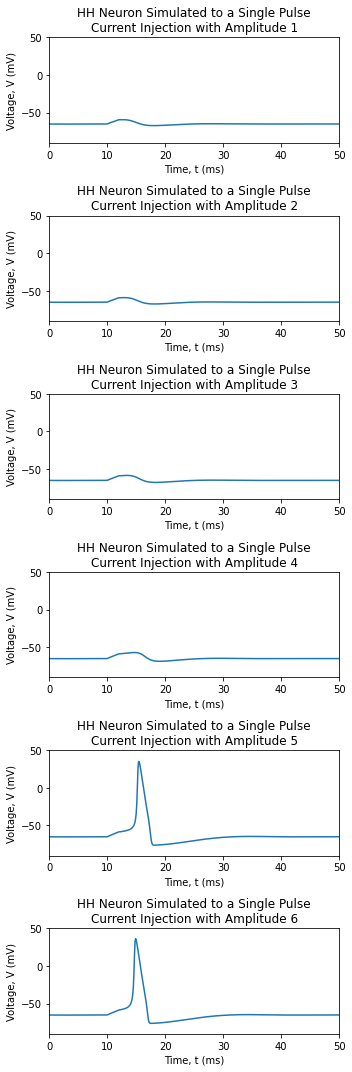

In [112]:
# You can use the following code to define some input current and call your HH_EX1a function.

iamp = np.arange(3.5,4.1,0.1) # some amplitudes to loop over
tstep = [10, 12] # start and stop of the step current

runner1a = HodgkinHuxley(np.arange(0.0, 50.0, 0.1)) # simulate for 50ms
runner1a.HH_EX1a(iamp, tstep)

### Written answer 1a

* What is the spike threshold?

The spike threshold is calculated and printed by the code above for each input current amplitude. The calculation is based on eq.3 from this paper: [A Threshold Equation for Action Potential Initiation](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000265).

* Bonus: Does the spike threshold depend on the duration of the pulse?

Yes, because for single pulse injection, the threshold is reached by injection a certain amount of charge. Therefore, the longer the duration of the pulse is, the lower the current amplitude is required.

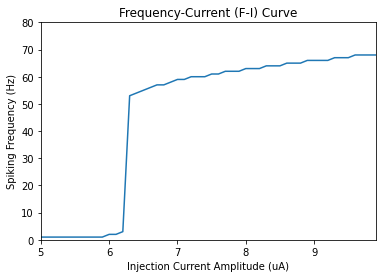

In [13]:
# You can use the following code to define some input current and call your HH_EX1b function.

iamp = np.arange(5,10,0.1) # some amplitudes to loop over
tstep = [1, 1000] # start and stop of the step current

runner1b = HodgkinHuxley(np.arange(0.0, 1000.0, 0.1)) # simulate for 1000ms
runner1b.HH_EX1b(iamp, tstep)

### Written answer 1b

* Characterize the voltage response as function of the current amplitude.

The voltage change in response to injection current can be generally described as spiking or non-spiking. The spiking activity is characterized by frequency when a direct current is injected.From the F-I curve, spiking frequency remains 0 below a certain current amplitude, and discontinuously increases to a large frequency and gradualy increases against current amplitude

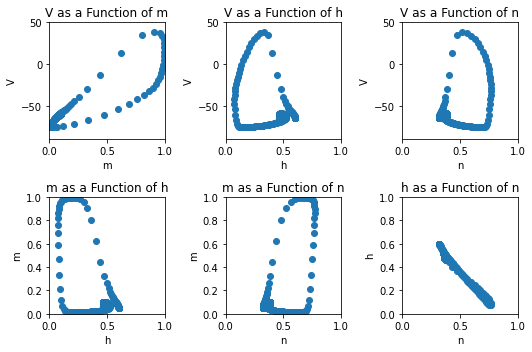

In [117]:
# You can use the following code to define some input current and call your HH_EX1c function.

iamp = 5 # some amplitudes to loop over
tstep = [1, 1000] # start and stop of the step current

runner1c = HodgkinHuxley(np.arange(0.0, 1000.0, 0.1)) # simulate for 1000ms
runner1c.HH_EX1c(iamp, tstep)

### Written answer 1c

* Identify pairs that are most strongly correlated. How can this identification help in reducing the neuron model’s dimension?

h and n are very strongly correlated: they seem to have a strong negative correlation. V and m also have a rather strong positive correlation.

* Does the choice of current amplitude affect which pairs of variables are most correlated?

After inspecting the correlations at various different input amplitudes, I found the two correlations stated above remained strong. The correlation may be affected, but these two pairs remained the most correlated.

# Exercise 2 - From four to two dimensions
Simulate a FitzHugh-Nagumo neuron model.
* Plot the f-I curve.
* Is it similar to what you got for the HH neuron?
* Are there ways in which the two models are different?
* Try to think of a scenario where it would be important to simulate the more complicated neuron model.

Hint for simulating FitzHugh-Nagumo model:
You have already simulated the Hodgkin-Huxley model: four coupled differential equations

\begin{aligned}
&C \frac{\mathrm{d} V}{\mathrm{~d} t}=-\bar{g}_{\mathrm{K}} n^{4}\left(V-V_{\mathrm{K}}\right)-\bar{g}_{\mathrm{Na}} m^{3} h\left(V-V_{\mathrm{Na}}\right)-\bar{g}_{1}\left(V-V_{\mathrm{l}}\right)+I \\
&\frac{\mathrm{d} n}{\mathrm{~d} t}=\alpha_{n}(V)(1-n)+\beta_{n}(V) n \\
&\frac{\mathrm{d} m}{\mathrm{~d} t}=\alpha_{m}(V)(1-m)+\beta_{m}(V) m \\
&\frac{\mathrm{d} h}{\mathrm{~d} t}=\alpha_{h}(V)(1-h)+\beta_{h}(V) h
\end{aligned}

The right hand side of each equation is the time derivative of the corresponding state variable. The python code computes this time derivative and puts it into a ODE solver.

To simulate the FitzHugh-Nagumo model, notice that the system of equations can be written in the same form. Here the system of equations is simpler: two ordinary differential equations.

FitzHugh-Nagumo Equations:
\begin{aligned}
&\frac{\mathrm{d} V}{\mathrm{~d} t}=V-\frac{1}{3} V^{3}-W+I \\
&\frac{\mathrm{d} W}{\mathrm{~d} t}=0.08(V+0.7-0.8 W)
\end{aligned}

In [105]:
class FitzHughNagumo():
    def __init__(self,time):
        self.t = time

    def I_inj(self, t, iinj):
        """
        External Current
        """
        return iinj[0]*(t>iinj[1]) - iinj[0]*(t>iinj[2])

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate
        |  :return: calculate membrane potential & activation variable
        """
        V, W = X

        dVdt = V - (1/3)*(V**3) - W + self.I_inj(t,self.iinj)
        dWdt = 0.08*(V + 0.7 - 0.8*W)
        return dVdt, dWdt

    def FN_EX2(self,iamp,tstep):
        """
        Simulate a FitzHugh-Nagumo neuron model.
        * Plot the f-I curve.
        * Is it similar to what you got for the HH neuron?
        * Are there ways in which the two models are different?
        * Try to think of a scenario where it would be important to simulate the more complicated neuron model.
        """

        frequencies = []
        for i0 in range(0,np.size(iamp)):           # loop over different amplidtudes
          self.iinj = [iamp[i0],tstep[0],tstep[1]]  # set the amplitude and start/ stop of the injected step current
          X = odeint(self.dALLdt, [-1, 0], self.t, args=(self,))
          V = X[:,0]
          W = X[:,1]
          peaks = sps.find_peaks(V,0)
          frequencies.append(len(peaks[0]))

        # Plot the f-I curve.
        plt.figure(4, figsize = (5,5))
        plt.plot(iamp, frequencies)
        plt.xlim([iamp[0],iamp[len(iamp)-1]])
        plt.ylim([0,80])
        plt.title("Frequency-Current (F-I) Curve")
        plt.xlabel("Injection Current Amplitude (uA)")
        plt.ylabel("Spiking Frequency (Hz)")


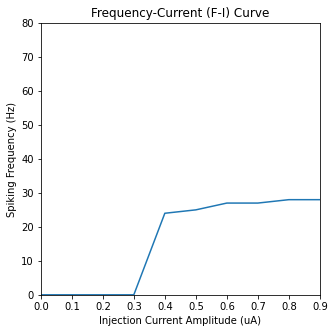

In [119]:
# You can use the following code to define some input current and call your FN_EX2 function.

runner2 = FitzHughNagumo(np.arange(0,1000,0.1))
runner2.FN_EX2(np.arange(0,1,0.1),[1,1000])

### Written answer 2

* Is it similar to what you got for the HH neuron?

Yes, it is similar in that it has a sudden increase in spiking frequency, and then a gradual increase following it.

* Are there ways in which the two models are different?

The spiking frequency is lower than that of the HH neuron in general. The input current that is required to cause a high spiking frequency is also lower than that of the HH neuron.

* Try to think of a scenario where it would be important to simulate the more complicated neuron model.

The F-N model reduces the three variables m, h, n to a single W, assuming that the relationships among these variables hold, and that the dynamics of m is fast than h and n. However, in special situations such as chemical/pharmacological interventions of a neuron, the sodium activation dynamics can be changed whilst others remain. The HH model could account for it simply by modifying the m dynamics accordingly, yet the F-N model would require recomputation of W entirely.

# Exercise 3 - From two to one dimension 
Simulate a leaky integrate and fire neuron, subject to direct current injection.

* Plot the f-I curve.
  * What aspects of the f-I curves of Exercises 1a, 1b does it capture?
  * What aspects does it not capture?
* Try to think of a scenario where it would be important to simulate the more complicated neuron model.



**Useful resources:**

[NMA, week 2, day 3, tutorial 1](https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html)

Section 1: implementation

Section 2: inputs

Section 3: f-I curve

Text(0, 0.5, 'Spiking Frequency (Hz)')

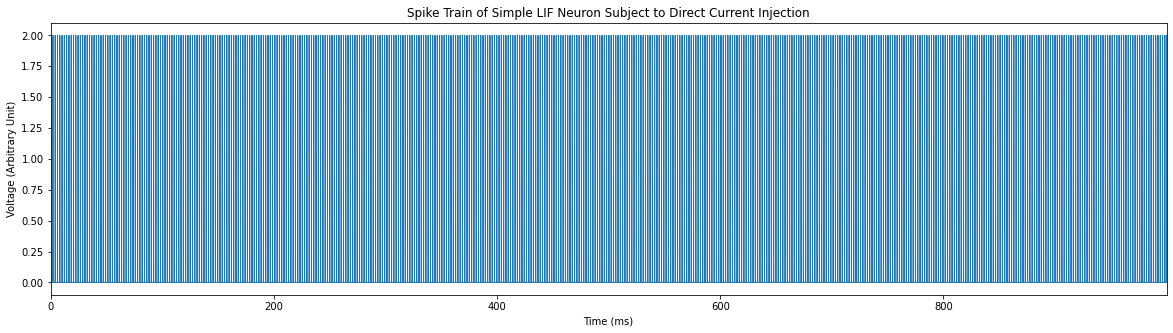

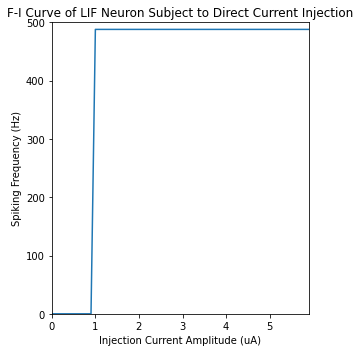

In [118]:

V_init = 0 # initial voltage
Vth = 1    # threshold voltage
Vr  = 0    # reset voltage
tref = 2   # refractory period [ms]
dt = 0.05  # integration timestep [ms]
T  = 1000  # simulation duration [ms]

t      = np.arange(0.0, T, dt)          # time array
InjAmp = np.arange(0,6,0.1)             # injected amplitude  
freq   = np.zeros(np.size(InjAmp),)     # frequency array
Lt     = np.size(t)
Vt     = np.zeros([np.size(InjAmp),Lt]) # voltage trace array

# Please finish the implementation of the LIF below

def run_LIF(Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):
    if tr > 0:  # check if in refractory period
      v[it] = Vr  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period
    elif v[it] >= Vth:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      tr = tref / dt  # set refractory time
    
    # Calculate the increment of the membrane potential
    dv = -v[it] + Iinj[it]

    # Update the membrane potential
    v[it + 1] = v[it] + dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes

# Simulate LIF model
v, sp = run_LIF(Iinj=2)

# Visualize spike train
plt.figure(5, figsize = (20, 5))
plt.plot(t, v, linewidth = 1)
plt.xlim(t[0],t[len(t)-1])
plt.title("Spike Train of Simple LIF Neuron Subject to Direct Current Injection")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (Arbitrary Unit)")

# Input iamp to loop over
ticker = 0
for I in InjAmp:
  v, sp = run_LIF(I)
  freq[ticker,] = len(sp)
  Vt[ticker,:] = v
  ticker = ticker + 1

# Plot F-I curve
plt.figure(6, figsize=(5,5), tight_layout = True)
plt.plot(InjAmp,freq)
plt.xlim(InjAmp[0],InjAmp[len(InjAmp)-1])
plt.ylim([0,500])
plt.title("F-I Curve of LIF Neuron Subject to Direct Current Injection")
plt.xlabel("Injection Current Amplitude (uA)")
plt.ylabel("Spiking Frequency (Hz)")


### Written answer 3

* What aspects of the f-I curves of Exercises 1a, 1b does it capture?

It captures the discontinuity from non-spiking to spiking activity as injection current amplitude increases.

* What aspects does it not capture?

The main drawback of the LIF model is that it doesn’t account for the refractory period after spikes, which explains why the gradual change depending on current amplitude is not seen for a simple LIF neuron.

* Try to think of a scenario where it would be important to simulate the more complicated neuron model.

The spiking frequency itself may encode information in a neuron. As the simple LIF neuron does not capture the gradually changing spiking frequency, such encoding method is not available in the neuron. Additionally, in a large complex network instead of an isolated situation, the LIF model cannot account for inhibitory inputs and its spike shape does not depend on the input current.

# Exercise 4
Simulate a **LIF** neuron subject a noisy input current (using uncorrelated Gaussian noise). For this exercise it is sufficient to generate gaussian noise centered at 0 while varying the standard deviation. Hint: you can use [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) to draw (pseudo) random numbers from a gaussian distribution.

* Plot the **f-I curve**: average spike frequency as a function of the standard deviation of the input.

  Do this for a few different values of the standard deviation of the input noise.

* Plot the inter-spike-interval distribution of the neuron.

  Describe in words what the inter-spike-interval distribution would be if the input was constant (with no noise)?

  Comment on how these distributions can be used to characterize the input statistics.

Text(0.5, 0, 'Inter-Spike-Interval (ms)')

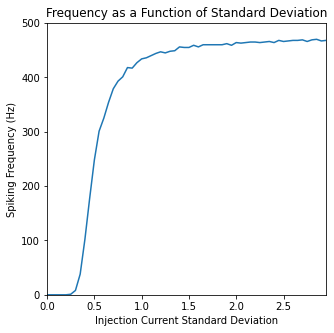

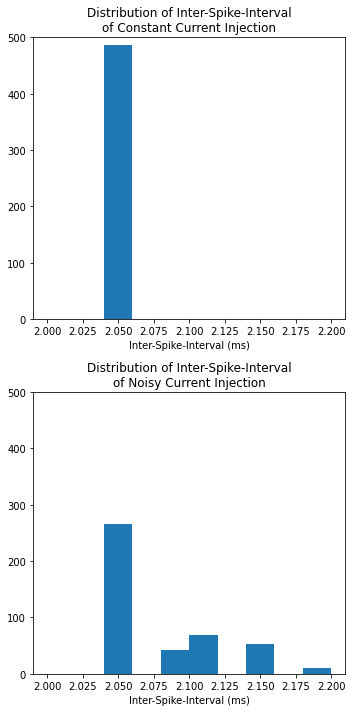

In [110]:
def my_GWN(mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Generate GWN
  # we divide here by 1000 to convert units to sec.
  #I_gwn = mu + sig * np.random.randn(Lt)
  I_gwn = np.random.normal(loc = mu, scale = sig, size = Lt)

  return I_gwn

# Input sig to loop over
sigArray = np.arange(0.0,3.0,0.05)
ticker = 0
for sig in sigArray:
  I = my_GWN(0.0, sig)
  v, sp = run_LIF(I)
  freq[ticker,] = len(sp)
  Vt[ticker,:] = v
  ticker = ticker + 1

# Plot F-I curve
plt.figure(7, figsize=(5,5))
plt.plot(sigArray,freq)
plt.xlim(sigArray[0],sigArray[len(sigArray)-1])
plt.ylim([0,500])
plt.title("Frequency as a Function of Standard Deviation")
plt.xlabel("Injection Current Standard Deviation")
plt.ylabel("Spiking Frequency (Hz)")

# Plot ISI distributions for constant and noisy injection current of amplitude 2 uA and standard deviation of 5
plt.figure(8, figsize = (5,10), tight_layout = True)

plt.subplot(211)
v, sp = run_LIF(2.0)
constantDiff = np.diff(sp)
plt.hist(constantDiff, 10, (2.0,2.2))
plt.ylim([0,500])
plt.title("Distribution of Inter-Spike-Interval\nof Constant Current Injection")
plt.xlabel("Inter-Spike-Interval (ms)")

plt.subplot(212)
I = my_GWN(2.0, 5.0)
v, sp = run_LIF(I)
noisyDiff = np.diff(sp)
plt.hist(noisyDiff, 10, (2.0,2.2))
plt.ylim([0,500])
plt.title("Distribution of Inter-Spike-Interval\nof Noisy Current Injection")
plt.xlabel("Inter-Spike-Interval (ms)")


### Written answer 4

* Describe in words what the inter-spike-interval distribution would be if the input was constant (with no noise)?

The inter-spike-interval would be constant if the input was constant. The distribution would reside in only one bin.

* Comment on how these distributions can be used to characterize the input statistics.

The range of the distributions should be related to the standard deviation of the input noise. Therefore, these distributions can be used to infer the variance of the input noise.